**Libraries**

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:

import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from tqdm import tqdm

# **Dataset and Preprocessing:**

The given Dataset is called `"animal_dataset"` which contains 3 classes labeled as `('dog', 'cat', 'panda')` and all every class contains 100 images of the subject as their name suggests

In [33]:
path = "/content/drive/MyDrive/animal_dataset/animal_dataset"
classes = ['cat', 'dog', 'panda']
classLabel = {'cat': 0, 'dog': 1, 'panda': 2}
imgEachClass = {'cat': 100, 'dog': 100, 'panda': 100}
data = []
for cls in classes:
    folder = os.path.join(path, cls)
    imgs = os.listdir(folder)
    selection = random.sample(imgs, imgEachClass[cls])
    for img_name in selection:
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        gray_scale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray_scale, (32, 32))
        data.append((resize, classLabel[cls], cls))

print(f"Total Number of Images: {len(data)}")
random.shuffle(data)


Total Number of Images: 300


In this preprocessing stage,Each selected image undergoes two key transformations, 1. conversion to grayscale and 2. resizing to a uniform 32×32 pixel resolution to standardize input dimensions and reduce computational complexity. The processed images, along with their corresponding numerical labels textual class names, are stored in a structured list called data. The dataset is shuffled to introduce randomness, This optimizes both performance and reliability

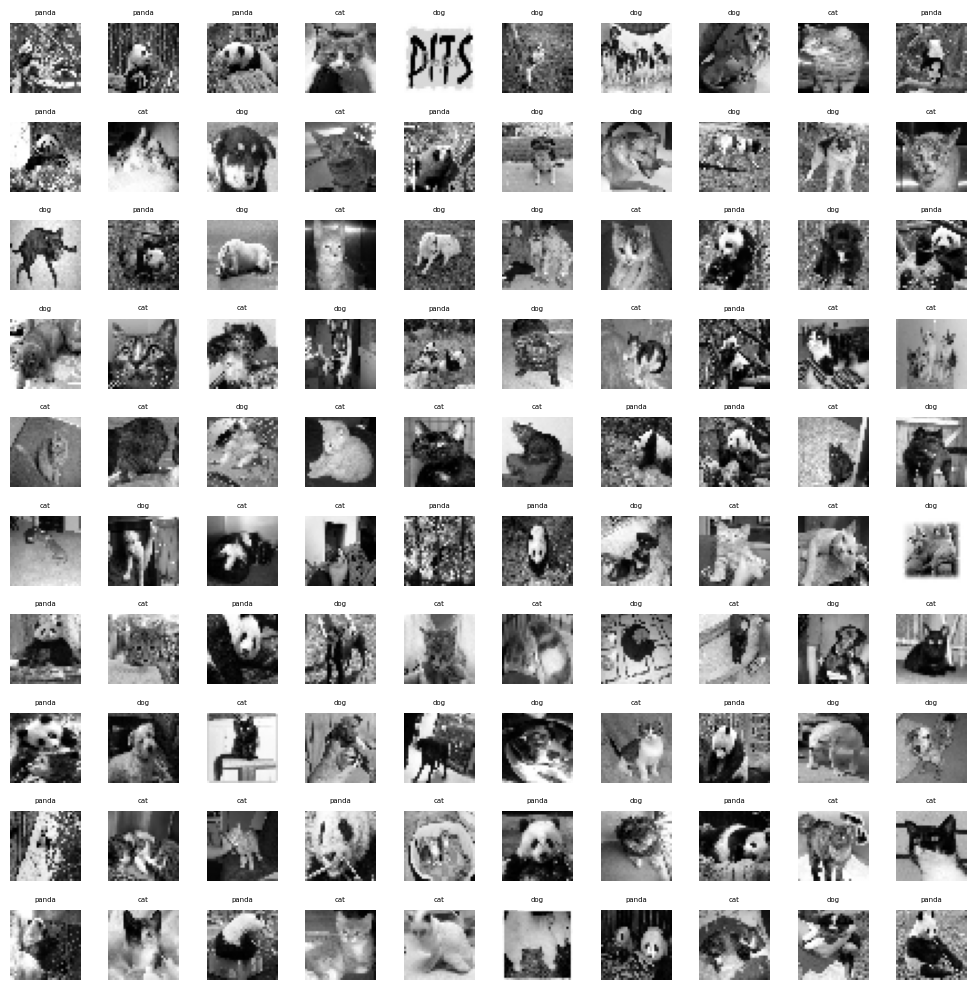

In [25]:
plt.figure(figsize=(10, 10))
for i in range(100):
    img, label, name = data[i]
    plt.subplot(10, 10, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(name, fontsize=5)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Checking The Results**

This above sections ensures that data has been loaded as well as turned grayscaled 32x32 images on a 10x10 grid along with their associated class and label info

# **Model Building and Evaluation:**



In [26]:
def manhattan(a,b):
    return np.sum(np.abs(a-b))

def euclidean(a,b):
    return np.sqrt(np.sum((a-b)**2))

Configuring Distance Functions, In this case L1 (Manhattan) & L2 (Euclidean) which will be used to compute the distance in each image and training sets


In [27]:
fold_size = len(data) // 5 #20 images in each fold
folds = [data[i*fold_size : (i+1)*fold_size] for i in range(5)]


The dataset is split into 5 same sized folds to peroform 5-fold cross-validation.

In [28]:
def knn(folds, distance_func, K, use_tqdm=True):
    fold_accuracies = []

    for i in range(5):
        val_fold = folds[i]
        train_folds = folds[:i] + folds[i+1:]
        train_data = []
        for f in train_folds:
            train_data.extend(f)

        val_x = [x[0] for x in val_fold]
        val_y = [x[1] for x in val_fold]
        train_x = [x[0] for x in train_data]
        train_y = [x[1] for x in train_data]

        accuracies = []

        for k in K:
            correct = 0

            itr = range(len(val_x))
            if use_tqdm:
                itr = tqdm(itr, desc=f"K = {k}, {i+1}-Fold")


            for j in itr:
                distances = []

                for m in range(len(train_x)):
                    d = distance_func(val_x[j], train_x[m])
                    distances.append((d, train_y[m]))

                distances.sort(key=lambda x: x[0])
                top_k = distances[:k]


                label_count = {}
                for d, label in top_k:
                    if label not in label_count:
                        label_count[label] = 1
                    else:
                        label_count[label] += 1

                pred_label = max(label_count, key=label_count.get)

                if pred_label == val_y[j]:
                    correct += 1

            acc = (correct / len(val_x)) * 100
            accuracies.append(acc)

        fold_accuracies.append(accuracies)
        average_accuracies = np.mean(fold_accuracies, axis=0)

    return fold_accuracies, average_accuracies
K = np.arange(1, 41)

# **What Actually Happened Above?**

We used the **K-Nearest Neighbors KNN** algorithm to train the dataset with **5-fold cross-validation**. Below are the detailed steps of the process:


### **1. Data Splitting for Cross-Validation**
- The dataset is divided into **5 folds**.
- For each fold:
  - **1 fold** is used as the **validation set**.
  - The **remaining 4 folds** are combined to form the **training set**.


### **2. Separate Features and Labels**
- Featuresand labels are separated for both the **training** and **validation** sets.


### **3. Iterate Over K Values**
- For each fold, the value of **K** ranges from **1 to 40**.


### **4. Distance Calculation**
- For each value of **K**, compute the distance between:
  - Every **validation image** and
  - All **training images**.
- Use either the **Manhattan** or **Euclidean** distance metric.


### **5. Sort Distances and Predict Labels**
- Sort the computed distances for each validation image in **ascending order**.
- Identify the **top K nearest neighbors** from the training set.
- Use a **majority vote** among these K neighbors to predict the class label for the validation image.


### **6. Store Accuracy**
- Calculate and store the **accuracy** for each value of **K** in the current fold in the `accuracies` list.


### **7. Aggregate Fold Accuracies**
- After processing all values of **K** for a fold, store the fold's accuracies in the `fold_accuracies` list.


### **8. Repeat for Both Distance Metrics**
- Call the `knn` function separately for both the **Manhattan** and **Euclidean** distance metrics.


### **9. Progress Tracking**
- Use the `tqdm` library to display a **progress bar**, making it easier to track the computation progress for each fold and each value of **K**.


# **Results and Analysis**



In [ ]:
fold_acc_L1, average_acc_L1 = knn(folds, manhattan, K)
fold_acc_L2, average_acc_L2 = knn(folds, euclidean, K)

def plot_knn_accuracy(K, fold_accuracies, average_accuracies, title, color):
    plt.figure(figsize=(10, 6))


    for i, fold_accuracy in enumerate(fold_accuracies):
        plt.plot(K, fold_accuracy, 'o-', label=f'{i+1}-Fold', alpha=0.7)


    plt.plot(K, average_accuracies, 'o-', color=color, label='Average Accuracy', linewidth=4)

    plt.xlabel('K')
    plt.ylabel('Accuracy(%)')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks(np.arange(0, 41, 1))
    plt.tight_layout()
    plt.show()

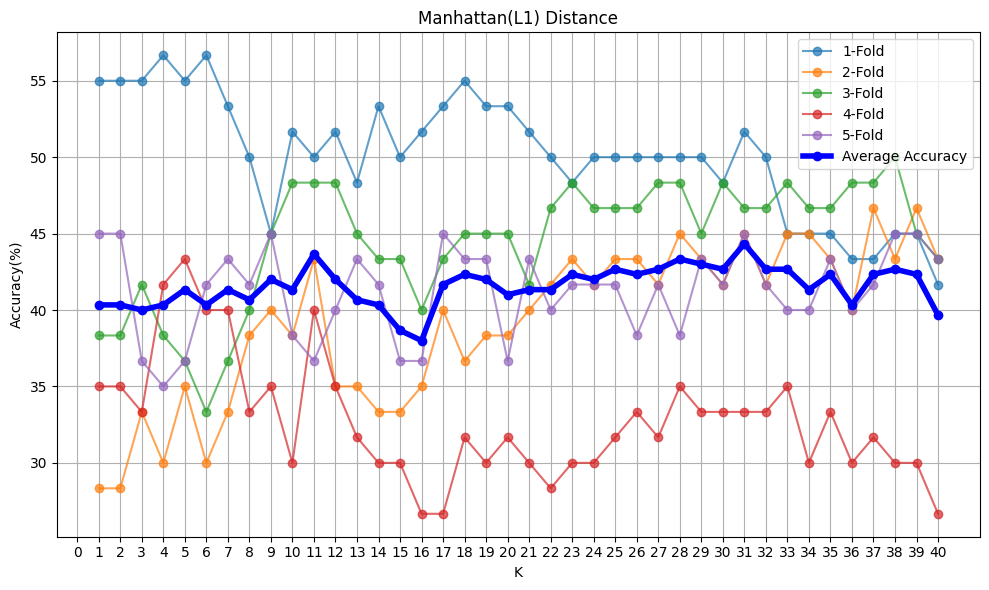

In [30]:
plot_knn_accuracy(K, fold_acc_L1, average_acc_L1, title='Manhattan(L1) Distance', color='blue')

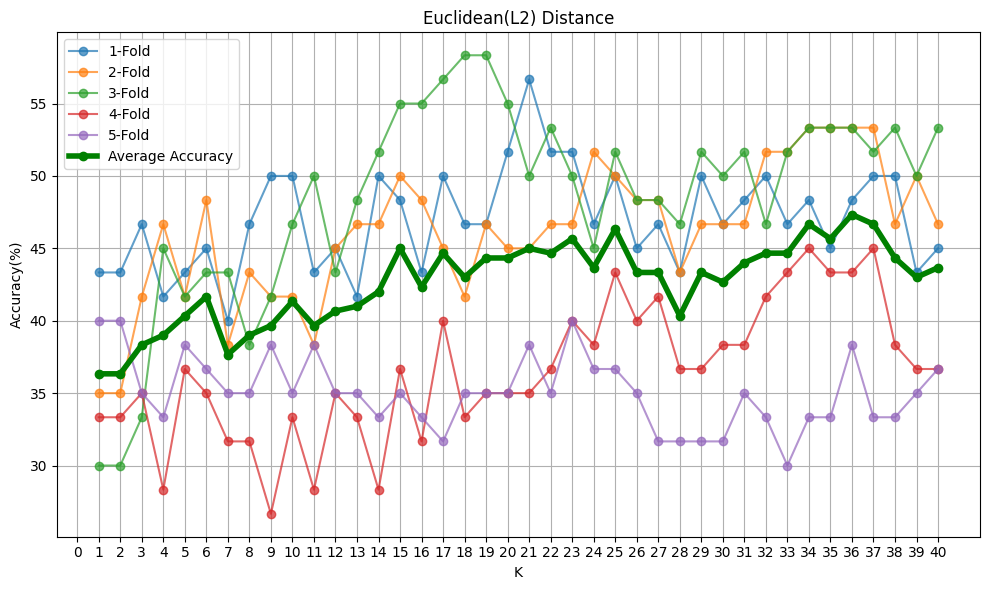

In [31]:
plot_knn_accuracy(K, fold_acc_L2, average_acc_L2, title='Euclidean(L2) Distance', color='green')

### **Accuracy Storage and Visualization**
- The **fold-wise accuracies** and **average accuracies** for each value of **K** are stored for both **Manhattan (L1)** and **Euclidean (L2)** distance metrics.
- The function **`plot_knn_accuracy`** is called to visualize the **average KNN accuracies** for both distance metrics across different values of **K** in separate graphs.


# **Discussion**


Comparing Manhattan (L1) and Euclidean (L2) Distances for KNN Classification

After running the KNN algorithm with 5-fold cross-validation on our grayscale dataset, I wanted to compare how the **Manhattan (L1)** and **Euclidean (L2)** distances performed. The plots above show the average accuracy for each value of K (from 1 to 40) across all folds. Here’s what I noticed and some thoughts on why things turned out the way they did:

---

### **Performance Comparison**
1. **Manhattan (L1) Distance:**
   - The average accuracy for L1 seems to hover around **40-45%**, with some peaks reaching up to **55%** for certain values of K.
   - The accuracy is a bit unstable, with noticeable fluctuations as K increases. This might suggest that L1 is more sensitive to the choice of K for this dataset.
   - Interestingly, the highest accuracy seems to occur around **K=20 to K=25**, but it drops off again afterward.

2. **Euclidean (L2) Distance:**
   - The average accuracy for L2 is slightly more consistent, generally staying between **40-45%**.
   - Unlike L1, L2 doesn’t show as many extreme spikes or dips, which might indicate it’s a bit more robust to changes in K.
   - The best performance for L2 seems to be around **K=32 to K=36**, where the accuracy stabilizes near the higher end of the range.

---

### **Why the Differences?**
- **Dataset Characteristics:**
  Our dataset consists of grayscale images, which means we’re dealing with pixel intensity values. Since grayscale images have less information compared to RGB, the choice of distance metric can have a noticeable impact. Manhattan distance (L1) tends to be less sensitive to outliers, while Euclidean distance (L2) can be influenced more by larger differences in pixel values.

- **Nature of Features:**
  The features here are pixel values, and the distance metrics calculate similarity differently. L1 sums the absolute differences, while L2 sums the squared differences. If the dataset has a lot of small variations (noise), L1 might perform better because it’s less affected by extreme values. However, in our case, L2 seems to provide slightly more stable results, which could mean that the variations in pixel intensities are not extreme enough to favor L1.

- **Complexity of Classes:**
  The classes (cat, dog, panda) might have overlapping features in grayscale, making it harder for KNN to distinguish between them. This could explain why the accuracy isn’t higher overall. The fact that L2 performs slightly better might suggest that the Euclidean distance is capturing the overall structure of the images more effectively for this dataset.


### **Limitations & Improvements**
- **Limitations:**
  - Low accuracy (~40-50%) due to raw pixel usage and grayscale limitations.
  - Performance varies with K, indicating poor generalization.

- **Improvements:**
  - Use **PCA/edge detection** for better features.
  - Try **SVM/Random Forest** classifiers.
  - Tune hyperparameters or use **weighted KNN**.
  - Apply **data augmentation** (rotation, flipping).



### **Conclusion**
Overall, the Euclidean (L2) distance seems to perform slightly better and more consistently than the Manhattan (L1) distance for this grayscale dataset. However, the accuracy is still not very high, which suggests that KNN with raw pixel values might not be the most effective approach. Exploring other feature extraction methods or classifiers could be the next step to improve performance.


# **TOP 5 PREDICTIONS**



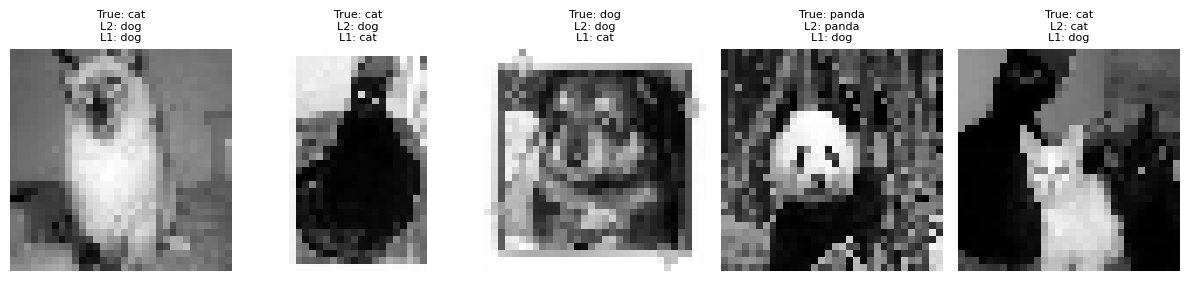

In [32]:
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
test_data = data[split_idx:]

train_x = [x[0] for x in train_data]
train_y = [x[1] for x in train_data]
test_x = [x[0] for x in test_data]
test_y = [x[1] for x in test_data]
test_names = [x[2] for x in test_data]

def predict_knn(X_train, y_train, X_test, k, dist_func):
    predictions = []
    for test_img in X_test:
        distances = []
        for i in range(len(X_train)):
            dist = dist_func(test_img, X_train[i])
            distances.append((dist, y_train[i]))
        distances.sort(key=lambda x: x[0])
        top_k = distances[:k]

        # Majority vote
        label_count = {}
        for d, label in top_k:
            label_count[label] = label_count.get(label, 0) + 1
        pred_label = max(label_count, key=label_count.get)
        predictions.append(pred_label)
    return predictions

# selecting top 5 test samples
k = 5
top5_test_imgs = test_x[:5]
top5_true_labels = test_y[:5]
top5_names = test_names[:5]

# Predictions using both distances
top5_preds_euclidean = predict_knn(train_x, train_y, top5_test_imgs, k, euclidean)
top5_preds_manhattan = predict_knn(train_x, train_y, top5_test_imgs, k, manhattan)

class_names = {v: k for k, v in classLabel.items()}

# displaying images and predictions
plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(top5_test_imgs[i], cmap='gray')
    plt.title(f"True: {class_names[top5_true_labels[i]]}\nL2: {class_names[top5_preds_euclidean[i]]}\nL1: {class_names[top5_preds_manhattan[i]]}", fontsize=8)
    plt.axis('off')
plt.tight_layout()
plt.show()


A thing to note that KNN often Misclassifies therefore isn't stable enough to use in Critical Systems as the TOP 5 Predictions still makes mistakes.